<a href="https://colab.research.google.com/github/freud-sensei/imfine_torch/blob/main/%5B%EC%96%B4%EB%91%A0%EC%86%8D%EC%9D%98%ED%9A%83%EB%B6%88%5D_LSTM%EC%9D%84_%EC%9D%B4%EC%9A%A9%ED%95%9C_%EB%84%A4%EC%9D%B4%EB%B2%84_%EC%98%81%ED%99%94_%EB%A6%AC%EB%B7%B0_%EB%B6%84%EB%A5%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 전처리
* \# of samples: 200,000
* label: 리뷰가 긍정인 경우 1, 부정인 경우 0

In [ ]:
!pip install konlpy

In [ ]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Mecab
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from collections import Counter

## 데이터 로드하기

In [ ]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")

('ratings_test.txt', <http.client.HTTPMessage at 0x7d431105add0>)

In [ ]:
train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        150000 non-null  int64 
 1   document  149995 non-null  object
 2   label     150000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.4+ MB


In [ ]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        50000 non-null  int64 
 1   document  49997 non-null  object
 2   label     50000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.1+ MB


## 데이터 정제하기

In [ ]:
# 중복된 행이 있는가?
train_data['document'].duplicated().sum()

3817

In [ ]:
# 있는 것 같으니 없애주자
train_data = train_data.drop_duplicates(subset='document')
train_data.shape

(146183, 3)

In [ ]:
train_data['document'].duplicated().sum()

0

In [ ]:
train_data['label'].value_counts()

0    73342
1    72841
Name: label, dtype: int64

In [ ]:
# 결측치 행이 있는가?
train_data.isna().sum()

id          0
document    1
label       0
dtype: int64

In [ ]:
# 결측치 행을 찾아라!
train_data.loc[train_data['document'].isna()]

,id,document,label
25857,2172111,NaN,1


In [ ]:
train_data = train_data.dropna(how='any')
print(train_data.isna().sum())

id          0
document    0
label       0
dtype: int64


In [ ]:
print(train_data.shape)

(146182, 3)


In [ ]:
# 데이터의 전처리: 특수문자 등을 제거한다.
train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [ ]:
eng_text = 'do!!! you expect... people~ to~ read~ the FAQ, etc. and actually accept hard~! atheism?@@'
print(re.sub(r'[^A-Za-z ]', '', eng_text)) # 알파벳, 스페이스 빼고 제거

do you expect people to read the FAQ etc and actually accept hard atheism


In [ ]:
train_data['document'] = train_data['document'].str.replace(r"[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "", regex=True)
train_data.head()

,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1


In [ ]:
# whitespace만 있거나 빈 값을 가진 행을 Null 값으로 변경
train_data['document'] = train_data['document'].str.replace('^ +', "", regex=True)
train_data['document'] = train_data['document'].replace('', np.nan)
print(train_data.isna().sum())

id            0
document    789
label         0
dtype: int64


In [ ]:
train_data.loc[train_data['document'].isna()].head(5)

,id,document,label
404,4221289,NaN,0
412,9509970,NaN,1
470,10147571,NaN,1
584,7117896,NaN,0
593,6478189,NaN,0


In [ ]:
train_data = train_data.dropna(how='any')
print(train_data.shape)

(145393, 3)


In [ ]:
# 이 모든 과정을 테스트 데이터에도 진행해야 함
test_data = test_data.drop_duplicates(subset='document')
test_data['document'] = test_data['document'].str.replace(r"[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "", regex=True)
test_data['document'] = test_data['document'].str.replace(r"^ +", "", regex=True)
test_data['document'] = test_data['document'].replace('', np.nan)
test_data = test_data.dropna(how='any')
print(test_data.shape)

(48852, 3)


## 토큰

In [ ]:
# 불용어 지정
stopwords = ['도', '는', '다', '의', '가', '이', '은', '한',
             '에', '하', '고', '을', '를', '인', '듯', '과',
             '와', '네', '들', '듯', '지', '임', '게']

In [ ]:
!pip install soynlp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 416.8/416.8 kB 3.5 MB/s eta 0:00:00


In [ ]:
from konlpy.tag import Okt
okt = Okt()
okt.morphs("아제아제 바라아제 바라승아제, 모지 사바하", stem=True)

['아', '제아', '제', '바라다', '제', '바라다', '승아', '제', ',', '모', '지', '사', '바하']

In [ ]:
# 트레이닝 데이터에 대한 토큰화
X_train = []
for sentence in tqdm(train_data['document']):
  tokenized_sentence = okt.morphs(sentence, stem=True)
  stopwords_removed_sentence = [word for word in tokenized_sentence if word not in stopwords]
  X_train.append(stopwords_removed_sentence)

print(X_train[:3])

100%|██████████| 145393/145393 [13:52<00:00, 174.71it/s]

[['아', '더빙', '진짜', '짜증나다', '목소리'], ['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '조차', '가볍다', '않다'], ['너', '무재', '밓었', '다그', '래서', '보다', '추천']]


In [ ]:
# 테스트 데이터에 대한 토큰화
X_test = []
for sentence in tqdm(test_data['document']):
  tokenized_sentence = okt.morphs(sentence, stem=True)
  stopwords_removed_sentence = [word for word in tokenized_sentence if word not in stopwords]
  X_test.append(stopwords_removed_sentence)

100%|██████████| 48852/48852 [05:23<00:00, 151.03it/s]


## 학습 데이터, 검증 데이터, 테스트 데이터

In [ ]:
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=.2, random_state=0, stratify=y_train)
# stratify는 label의 비율을 균등하게 해 준다.

In [ ]:
print(np.sum(y_train == 0) / len(y_train)) # 트레이닝 데이터의 부정리뷰 비율
print(np.sum(y_valid == 0) / len(y_valid)) # 검증 데이터 중 부정리뷰 비율
print(np.sum(y_test == 0) / len(y_test)) # 테스트 데이터 중 부정리뷰 비율

0.5023814846020256
0.5023900409230029
0.4980758208466388


## 단어 집합 만들기

In [ ]:
word_list = []
for sentence in X_train:
  for word in sentence:
    word_list.append(word)

word_counts = Counter(word_list)
print(len(word_counts)) # 총 단어수

39613


In [ ]:
print(word_counts['영화']) # 단어 '영화'의 등장횟수
print(word_counts['공감']) # 단어 '공감'의 등장횟수

40264
784


In [ ]:
vocab = sorted(word_counts, key=word_counts.get, reverse=True)
# get 메서드는 주어진 요소의 개수를 반환
print(vocab[:10])

['영화', '보다', '하다', '없다', '이다', '있다', '좋다', '너무', '정말', '되다']


In [ ]:
# 단어 집합에 대한 점검
threshold = 3
total_count = len(word_counts)
rare_count = 0 # 빈도 < threshold
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 합
rare_freq = 0 # 빈도 < threshold인 단어의 등장 빈도수 합

for key, value in word_counts.items():
  total_freq += value
  if value < threshold:
    rare_count += 1
    rare_freq += value

print(total_count) # 단어집합의 크기
print(rare_count) # 등장빈도가 2회 이하
print(rare_count / total_count * 100) # 희귀단어의 비율
print(rare_freq / total_freq * 100) # 전체 등장빈도에서 희귀단어 등장 빈도 비율

39613
22212
56.07250145154369
2.1444348229860823


In [ ]:
# 총빈도수 2 이하인 단어 제거
vocab_size = total_count - rare_count
vocab = vocab[:vocab_size]
print(len(vocab)) # '최종' 단어집합의 크기

17401


## 정수 인코딩

In [ ]:
word_to_index = {}
word_to_index['<PAD>'] = 0
word_to_index['<UNK>'] = 1

for idx, word in enumerate(vocab):
  word_to_index[word] = idx + 2

print(len(word_to_index)) # PAD, UNK 토큰을 고려한 단어집합 크기

index_to_word = {v: idx for idx, v in word_to_index.items()}
print(index_to_word[1])

17403
<UNK>


In [ ]:
def texts_to_sequences(tokenized_data, word_to_index):
  encoded_data = []
  for sentence in tokenized_data:
    indices = []
    for word in sentence:
      try:
        indices.append(word_to_index[word])
      except KeyError:
        indices.append(word_to_index['<UNK>'])
    encoded_data.append(indices)
  return encoded_data

In [ ]:
encoded_X_train = texts_to_sequences(X_train, word_to_index)
encoded_X_valid = texts_to_sequences(X_valid, word_to_index)
encoded_X_test = texts_to_sequences(X_test, word_to_index)

for sentence in encoded_X_train[:2]:
  print(sentence)

[406, 2143, 41, 64]
[2355, 3126, 7, 2091, 581, 35, 755, 158]


In [ ]:
print([index_to_word[idx] for idx in encoded_X_train[0]])

['이야', '어쩜', '이렇다', '지루하다']


## 패딩

69
10.961088089138023


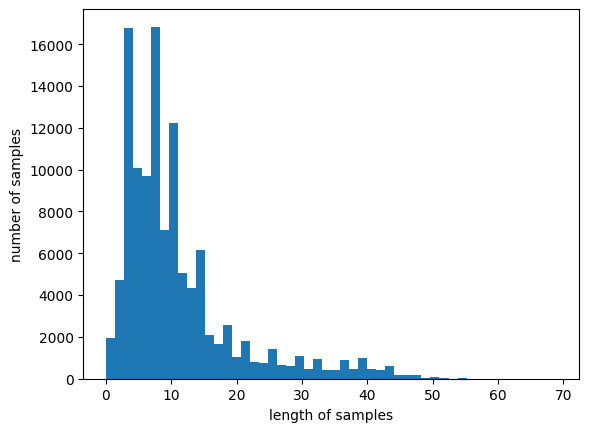

In [ ]:
print(max(len(review) for review in encoded_X_train)) # 리뷰의 최대 길이
print(sum(len(review) for review in encoded_X_train) / len(encoded_X_train)) # 리뷰의 평균 길이
plt.hist([len(review) for review in encoded_X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
def pad_sequences(sentences, max_len):
  features = np.zeros((len(sentences), max_len), dtype=int)
  for idx, sentence in enumerate(sentences):
    if len(sentence) != 0:
      features[idx, :len(sentence)] = np.array(sentence)[:max_len]
  return features

padded_X_train = pad_sequences(encoded_X_train, 30)
padded_X_valid = pad_sequences(encoded_X_valid, 30)
padded_X_test = pad_sequences(encoded_X_test, 30)

print(padded_X_train.shape)
print(padded_X_valid.shape)
print(padded_X_test.shape)

(116314, 30)
(29079, 30)
(48852, 30)


In [ ]:
padded_X_train[0]

array([ 406, 2143,   41,   64,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0])

In [ ]:
np.save('/content/drive/MyDrive/lstmdata/padded_X_train.npy', padded_X_train)
np.save('/content/drive/MyDrive/lstmdata/padded_X_valid.npy', padded_X_valid)
np.save('/content/drive/MyDrive/lstmdata/padded_X_test.npy', padded_X_test)
np.save('/content/drive/MyDrive/lstmdata/y_train.npy', y_train)
np.save('/content/drive/MyDrive/lstmdata/y_valid.npy', y_valid)
np.save('/content/drive/MyDrive/lstmdata/y_test.npy', y_test)

# 모델 설계

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
import numpy as np
padded_X_train = np.load('/content/drive/MyDrive/lstmdata/padded_X_train.npy')
padded_X_valid = np.load('/content/drive/MyDrive/lstmdata/padded_X_valid.npy')
padded_X_test = np.load('/content/drive/MyDrive/lstmdata/padded_X_test.npy')
y_train = np.load('/content/drive/MyDrive/lstmdata/y_train.npy')
y_valid = np.load('/content/drive/MyDrive/lstmdata/y_valid.npy')
y_test = np.load('/content/drive/MyDrive/lstmdata/y_test.npy')

In [ ]:
y_train_tensor = torch.tensor(y_train)
y_valid_tensor = torch.tensor(y_valid)
y_test_tensor = torch.tensor(y_test)
print(y_train_tensor[:5])


tensor([0, 1, 1, 1, 1])


* 입력: (배치 크기, 문장 길이)의 텐서.
* 임베딩 층: (배치 크기, 문장 길이, 임베딩벡터의 차원)의 텐서.
* 출력층 직전: (배치 크기, 은닉층의 크기) - 마지막 시점 값만 전달
* 소프트맥스 회귀 후: (배치 크기, 카테고리 수)

In [ ]:
class TextClassifier(nn.Module):
  def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
    super().__init__()
    self.embedding = nn.Embedding(vocab_size, embedding_dim)
    self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
    self.fc = nn.Linear(hidden_dim, output_dim)

  def forward(self, x):
    embedded = self.embedding(x)
    lstm_out, (hidden, cell) = self.lstm(embedded) # LSTM은 hidden state, cell state 두개가 있음을 기억할 것
    # lstm_out: (batch_size, seq_length, hidden_dim)
    # hidden: (bum of layers(1), batch_size, hidden_dim)
    last_hidden = hidden.squeeze(0)
    logits = self.fc(last_hidden)
    return logits

In [ ]:
encoded_train = torch.tensor(padded_X_train).to(torch.int64)
train_dataset = torch.utils.data.TensorDataset(encoded_train, y_train_tensor)
train_dataloader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=32)

encoded_valid = torch.tensor(padded_X_valid).to(torch.int64)
valid_dataset = torch.utils.data.TensorDataset(encoded_valid, y_valid_tensor)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, shuffle=True, batch_size=1)

encoded_test = torch.tensor(padded_X_test).to(torch.int64)
test_dataset = torch.utils.data.TensorDataset(encoded_test, y_test_tensor)
test_dataloader = torch.utils.data.DataLoader(test_dataset, shuffle=True, batch_size=1)

In [ ]:
total_batch = len(train_dataloader)
print(total_batch) # 총 배치의 수

3635


In [ ]:
# hyperparams
embedding_dim = 100
hidden_dim = 128
output_dim = 2
learning_rate = .01
num_epochs = 10

vocab_size = 17403

model = TextClassifier(vocab_size, embedding_dim, hidden_dim, output_dim)
model.to(device)

TextClassifier(
  (embedding): Embedding(17403, 100)
  (lstm): LSTM(100, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)

In [ ]:
loss_f = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=.001)

# 평가코드 작성

In [ ]:
# 모델의 정확도를 측정
def calculate_accuracy(logits, labels):
  _, predicted = torch.max(logits, 1)
  correct = (predicted == labels).sum().item()
  total = labels.size(0)
  accuracy = correct / total
  return accuracy

In [ ]:
def evaluate(model, valid_dataloader, loss_f, device):
  val_loss = 0
  val_correct = 0
  val_total = 0
  model.eval()

  with torch.no_grad():
    for batch_X, batch_y in tqdm(valid_dataloader):
      batch_X, batch_y = batch_X.to(device), batch_y.to(device)
      logits = model(batch_X) # 모델의 예측값
      loss = loss_f(logits, batch_y) # 손실 계산

      # 정확도와 손실 계산
      val_loss += loss.item()
      val_correct += calculate_accuracy(logits, batch_y) * batch_y.size(0)
      val_total += batch_y.size(0)

    val_accuracy = val_correct / val_total
    val_loss /= len(valid_dataloader)
    return val_loss, val_accuracy

# 학습

In [ ]:
from tqdm import tqdm

In [ ]:
n_epochs = 5
best_val_loss = float('inf')


for epoch in range(n_epochs):
  # training
  train_loss = 0
  train_correct = 0
  train_total = 0
  model.train()

  for batch_X, batch_y in tqdm(train_dataloader):
    batch_X, batch_y = batch_X.to(device), batch_y.to(device)

    # batch X: (batch_size, max_len)
    logits = model(batch_X)

    # compute loss
    loss = loss_f(logits, batch_y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # training accuracy, loss
    train_loss += loss.item()
    train_correct += calculate_accuracy(logits, batch_y) * batch_y.size(0)
    train_total += batch_y.size(0)

  train_accuracy = train_correct / train_total
  train_loss /= len(train_dataloader)

  # validation
  val_loss, val_accuracy = evaluate(model, valid_dataloader, loss_f, device)

  print(f"Epoch {epoch + 1} / {n_epochs}:")
  print(f"Train Loss: {train_loss: .4f}, Train Accuracy: {train_accuracy: .4f}")
  print(f"Validation Loss: {val_loss: .4f}, Validation Accuracy: {val_accuracy: .4f}")

  if val_loss < best_val_loss:
    print(f"Val Loss imporved from {best_val_loss:.4f} to {val_loss:.4f}")
    best_val_loss = val_loss
    torch.save(model.state_dict(), 'best_model_checkpoint.pth')


100%|██████████| 29079/29079 [00:37<00:00, 778.86it/s] 


Epoch 1 / 5:
Train Loss:  0.2659, Train Accuracy:  0.8903
Validation Loss:  0.3609, Validation Accuracy:  0.8473
Val Loss imporved from inf to 0.3609


100%|██████████| 29079/29079 [00:26<00:00, 1088.41it/s]


Epoch 2 / 5:
Train Loss:  0.2107, Train Accuracy:  0.9161
Validation Loss:  0.3791, Validation Accuracy:  0.8480


100%|██████████| 29079/29079 [00:25<00:00, 1150.61it/s]


Epoch 3 / 5:
Train Loss:  0.1604, Train Accuracy:  0.9399
Validation Loss:  0.4166, Validation Accuracy:  0.8437


100%|██████████| 29079/29079 [00:25<00:00, 1144.78it/s]


Epoch 4 / 5:
Train Loss:  0.1209, Train Accuracy:  0.9558
Validation Loss:  0.4732, Validation Accuracy:  0.8430


100%|██████████| 29079/29079 [00:25<00:00, 1131.70it/s]

Epoch 5 / 5:
Train Loss:  0.0938, Train Accuracy:  0.9671
Validation Loss:  0.5333, Validation Accuracy:  0.8394


# 모델 로드 및 평가

In [ ]:
model.load_state_dict(torch.load('best_model_checkpoint.pth'))
model.to(device)

TextClassifier(
  (embedding): Embedding(17403, 100)
  (lstm): LSTM(100, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)

In [ ]:
test_loss, test_accuracy = evaluate(model, test_dataloader, loss_f, device)
print(test_loss)
print(test_accuracy)

100%|██████████| 48852/48852 [00:50<00:00, 964.36it/s]

0.3711308397301337
0.8456357979202489


# 모델 테스트